In [ ]:
# Imports


# os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  # Hide all INFO/WARNING/ERROR from TF
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Pretend no GPU exists
# os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.preprocessing import image_dataset_from_directory
import json


# Reproducability
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed(31415)

# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # to clean up output cells

DIR = "../input/leaves"
CLASS_NAMES = sorted(os.listdir(DIR))
with open("class_names.json", "w") as f:
    json.dump(CLASS_NAMES, f)

# Load training and validation sets
ds_valid_= image_dataset_from_directory(
    '../input/leaves',
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAMES,
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
    validation_split=0.2,
    subset='training',
    seed=123
)
ds_train_ = image_dataset_from_directory(
    '../input/leaves',
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAMES,
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
    validation_split=0.2,
    subset='training',
    seed=123
)

# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

Found 7221 files belonging to 8 classes.
Using 5777 files for training.
Found 7221 files belonging to 8 classes.
Using 5777 files for training.


In [100]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(8, activation='softmax'),
])

In [101]:
model.compile(
    optimizer=keras.optimizers.Adam(epsilon=0.01),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=100,
    verbose=0,
)

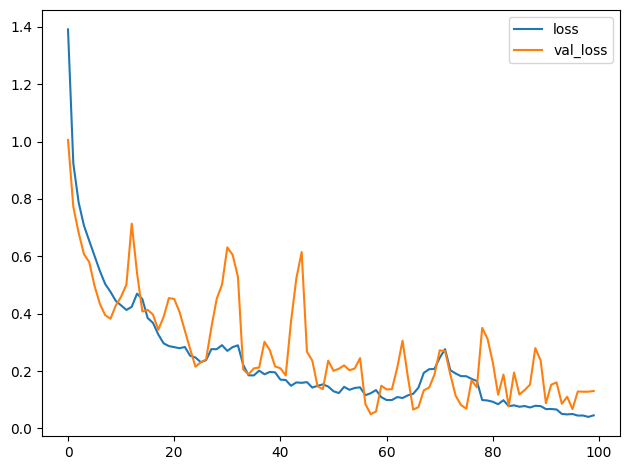

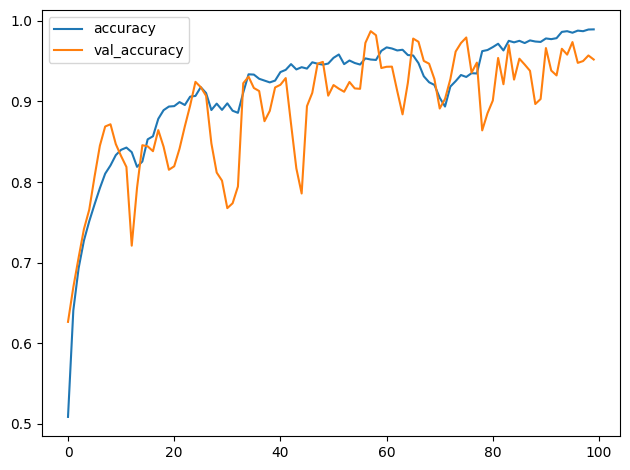

In [ ]:
import pandas as pd

history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot()

In [103]:
img = keras.utils.load_img("../input/leaves/Apple_Black_rot/image (1).JPG", target_size=(128, 128))
img_array = keras.utils.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

pred = model.predict(img_array)
predicted_class_idx = np.argmax(pred[0])
predicted_class = CLASS_NAMES[predicted_class_idx]

print(f"Predicted class: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Predicted class: Apple_Black_rot


In [108]:
model.save("my_model.keras")

In [109]:
import os
import numpy as np
from tensorflow import keras
from tensorflow.keras.preprocessing import image

# Set your constants
IMAGE_SIZE = 128  # or whatever your model expects
ROOT_DIR = "../input/leaves"  # directory to walk through

# If you don't have CLASS_NAMES anymore, you can recreate them:
CLASS_NAMES = sorted(os.listdir(ROOT_DIR))

# Tracking
total = 0
correct = 0

model2 = keras.models.load_model("my_model.keras")

# Go through every image in the directory tree
for root, dirs, files in os.walk(ROOT_DIR):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):  # check for valid image formats
            img_path = os.path.join(root, file)
            true_class = os.path.basename(root)

            # Load and preprocess image
            try:
                img = keras.utils.load_img(img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
                img_array = keras.utils.img_to_array(img) / 255.0  # normalize if needed
                img_array = np.expand_dims(img_array, axis=0)  # make it (1, 128, 128, 3)

                # Predict
                pred = model2.predict(img_array, verbose=0)
                predicted_class_idx = np.argmax(pred[0])
                predicted_class = CLASS_NAMES[predicted_class_idx]

                total += 1
                if predicted_class == true_class:
                    correct += 1

                accuracy = (correct / total) * 100
                print(f"🎯 Accuracy: {accuracy:.2f}% out of {total} images.")
                # print(f"Image: {img_path} -> Predicted class: {predicted_class}")

            except Exception as e:
                print(f"Error processing {img_path}: {e}")


🎯 Accuracy: 100.00% out of 1 images.
🎯 Accuracy: 100.00% out of 2 images.
🎯 Accuracy: 100.00% out of 3 images.
🎯 Accuracy: 100.00% out of 4 images.
🎯 Accuracy: 100.00% out of 5 images.
🎯 Accuracy: 100.00% out of 6 images.
🎯 Accuracy: 100.00% out of 7 images.
🎯 Accuracy: 100.00% out of 8 images.
🎯 Accuracy: 100.00% out of 9 images.
🎯 Accuracy: 100.00% out of 10 images.
🎯 Accuracy: 100.00% out of 11 images.
🎯 Accuracy: 100.00% out of 12 images.
🎯 Accuracy: 100.00% out of 13 images.
🎯 Accuracy: 100.00% out of 14 images.
🎯 Accuracy: 100.00% out of 15 images.
🎯 Accuracy: 100.00% out of 16 images.
🎯 Accuracy: 100.00% out of 17 images.
🎯 Accuracy: 100.00% out of 18 images.
🎯 Accuracy: 100.00% out of 19 images.
🎯 Accuracy: 100.00% out of 20 images.
🎯 Accuracy: 100.00% out of 21 images.
🎯 Accuracy: 100.00% out of 22 images.
🎯 Accuracy: 100.00% out of 23 images.
🎯 Accuracy: 100.00% out of 24 images.
🎯 Accuracy: 100.00% out of 25 images.
🎯 Accuracy: 100.00% out of 26 images.
🎯 Accuracy: 100.00% o

KeyboardInterrupt: 